In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.io import netcdf

import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt

import os
import logging

import numpy as np

import pickle
from pathlib import Path
from cartopy.util import add_cyclic_point
logger = logging.getLogger(__name__)

In [2]:
def get_scenarios_jsbach():
    """
        Return a List containing SCENARIO tag names
    """
    CLIM_SCENARIOS = [ 'ssp126', 'ssp370' ]
    CLIM_MODELS = [ 'mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr' ]
    return CLIM_SCENARIOS, CLIM_MODELS

In [3]:
def add_metadata(cube, field, fname):
    
    esm_id = fname.split('_')[1]
    ssp_id = fname.split('_')[2]

    iris.std_names.STD_NAMES['experiment_id'] = {'canonical units':'1'}
    
    #if not cube.coords("experiment_id"):
    climate_coord = iris.coords.AuxCoord(ssp_id, "experiment_id", units="1", long_name="experiment_id")
    cube.add_aux_coord(climate_coord)

    #if not cube.coords("realization"):
    esm_coord = iris.coords.AuxCoord(esm_id, "realization", units="1")
    cube.add_aux_coord(esm_coord)

In [4]:
def _get_land_fraction(cube):
    """Extract land fraction as :mod:`dask.array`."""
    fx_cube = None
    land_fraction = None
    errors = []
    
    try:
        fx_cube = cube.ancillary_variable('land_area_fraction')
    except iris.exceptions.AncillaryVariableNotFoundError:
        try:
            fx_cube = cube.ancillary_variable('sea_area_fraction')
        except iris.exceptions.AncillaryVariableNotFoundError:
            errors.append('Ancillary variables land/sea area fraction not '
                          'found in cube. Check ancillary data availability.')
            return (land_fraction, errors)

    land_fraction = fx_cube.core_data()
    
    if fx_cube.var_name == 'sftlf':
        land_fraction = fx_cube.core_data() / 100.0
    if fx_cube.var_name == 'sftof':
        land_fraction = 1.0 - fx_cube.core_data() / 100.0
    
    return (land_fraction, errors)

In [5]:
def weighting_landsea_fraction(cube, area_type):
    """Weight fields using land or sea fraction.

    This preprocessor function weights a field with its corresponding land or
    sea area fraction (value between 0 and 1). The application of this is
    important for most carbon cycle variables (and other land-surface outputs),
    which are e.g. reported in units of `kgC m-2`. This actually refers to 'per
    square meter of land/sea' and NOT 'per square meter of gridbox'. So in
    order to integrate these globally or regionally one has to both area-weight
    the quantity but also weight by the land/sea fraction.

    Parameters
    ----------
    cube : iris.cube.Cube
        Data cube to be weighted. It should have an
        :class:`iris.coords.AncillaryVariable` with standard name
        ``'land_area_fraction'`` or ``'sea_area_fraction'``. If both are
        present, only the ``'land_area_fraction'`` will be used.
    area_type : str
        Use land (``'land'``) or sea (``'sea'``) fraction for weighting.

    Returns
    -------
    iris.cube.Cube
        Land/sea fraction weighted cube.

    Raises
    ------
    TypeError
        ``area_type`` is not ``'land'`` or ``'sea'``.
    ValueError
        Land/sea fraction variables ``sftlf`` or ``sftof`` not found.
    """
    if area_type not in ('land', 'sea'):
        raise TypeError(
            f"Expected 'land' or 'sea' for area_type, got '{area_type}'")
    (land_fraction, errors) = _get_land_fraction(cube)
    if land_fraction is None:
        raise ValueError(
            f"Weighting of '{cube.var_name}' with '{area_type}' fraction "
            f"failed because of the following errors: {' '.join(errors)}")

    core_data = cube.core_data()
    if area_type == 'land':
        cube.data = core_data * land_fraction
    elif area_type == 'sea':
        cube.data = core_data * (1.0 - land_fraction)
    return cube

In [6]:
def add_ancillary_variable(cube, temp_ancil_cube):
    """Add cube as an ancillary variable in the cube containing the data.

    Parameters
    ----------
    cube: iris.cube.Cube
        Iris cube with input data.
    temp_ancil_cube: iris.cube.Cube
        Iris cube with ancillary data.

    Returns
    -------
    iris.cube.Cube
        Cube with added ancillary variables
    """
    
    cube_left_lat = cube.coord("longitude").points[0]
    cube_right_lat = cube.coord("longitude").points[-1]

    acube_left_lat = temp_ancil_cube.coord("longitude").points[0]
    acube_right_lat = temp_ancil_cube.coord("longitude").points[-1]

    if cube_left_lat != acube_left_lat:
        ancillary_cube = temp_ancil_cube.intersection(longitude=(-180,180), ignore_bounds=True )
    else:
        ancillary_cube = temp_ancil_cube
        
    ancillary_var = iris.coords.AncillaryVariable(
        ancillary_cube.core_data(),
        standard_name=ancillary_cube.standard_name,
        units=ancillary_cube.units,
        var_name=ancillary_cube.var_name,
        attributes=ancillary_cube.attributes)
    start_dim = cube.ndim - len(ancillary_var.shape)
    cube.add_ancillary_variable(ancillary_var, range(start_dim, cube.ndim))
    logger.debug('Added %s as ancillary variable in cube of %s.',
                 ancillary_cube.var_name, cube.var_name)

In [15]:
def main():

    make_maps=False
    region=0
    region_title=['Global','Tropics','NH-Temperate']
  
    varnames=['cVeg','cSoil','cLitter','cProduct','cHbpharv']
    
    SCENARIO_TITLES = ['agtobio', 'agtoaff', 'nattobio']
    PLOT_TITLES = ['Biocrops on ag land', 'Afforestation on ag land', 
                   'Biocrops on natural land'] 

    ssp, esm = get_scenarios_jsbach()
    nclim = len(esm)
    nssp = len(ssp)
    years = np.arange(2015,2100)     
    nyears = len(years)
    
    # First get the no land use change data
    plot_ctot = np.zeros([nssp,nclim,nyears])
    fig,axes=plt.subplots(3,2, figsize=[12,8])
    
    #PLOT THE NO LUC SCENARIO
    scenario_title = 'noluc'
    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')    
    ix=0
    iy=0

    
    for var in varnames:
        noluc,noluc_tr,noluc_te = retrieve_data_generic(var,'noluc','jsbach')
        
        if make_maps == True:
            map_diff(var,ssp,esm,SCENARIO_TITLES,PLOT_TITLES)

        # set axes
        ax=axes[iy,ix]
        ax.set_ylabel(r'$\Delta$' +var+' (PgC) '+region_title[region],fontsize=10)
        if iy==0:
            plot_title = 'JSBACH No LUC'
        else:
            plot_title = ' '
        ax.set_title(plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 
        

        for i1 in range(0,nssp):
            for i0 in range(0,nclim): 
                if region==0:
                    plot_cveg = noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_cveg = noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_cveg = noluc_te[ssp[i1]][esm[i0]]               
 
                ax.plot(years, plot_cveg[0]-plot_cveg[0][0], label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2) 
                plot_ctot[i1,i0,:] = plot_ctot[i1,i0,:] + (plot_cveg[0]-plot_cveg[0][0])

        ix+=1
        if ix==2:
            ix=0
            iy+=1

    ax=axes[iy,ix]
    ax.set_ylabel(r'$\Delta$ cTot (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 
    for i1 in range(0,nssp):
        for i0 in range(0,nclim): 
            ax.plot(years, plot_ctot[i1,i0,:], label=ssp[i1]+' '+esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2) 

    handles,labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
    plt.savefig('/bdd/ESM2025/WP10/analysis/figures/jsbach/jsbach_ALLcpools_'+\
                region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    


    #NOW GET THE LAND USE SCENARIOS AND PLOT EITHER THE DIFFERENCES OR THE RAW VALUES

    plot_diff = True
    for i2 in range(0,3):
        plot_ctot = np.zeros([nssp,nclim,nyears])
        
        scenario_title = SCENARIO_TITLES[i2]
 
        ix=0
        iy=0

        fig,axes=plt.subplots(3,2, figsize=[12,8])
        for var in varnames:
            cdata,cdata_tr,cdata_te = retrieve_data_generic(var,scenario_title,'jsbach')
            noluc,noluc_tr,noluc_te = retrieve_data_generic(var,'noluc','jsbach')

            # set axes
            ax=axes[iy,ix]
            ax.set_ylabel(r'$\Delta$' +var+' (PgC) '+region_title[region],fontsize=10)
            if iy==0:
                plot_title = PLOT_TITLES[i2]
                if plot_diff==True:
                    ax.set_title('JSBACH ('+plot_title+') - (no LUC scenario)',fontsize=12)
                else:
                    ax.set_title('JSBACH '+plot_title,fontsize=12)  
            else:
                plot_title = ' '
                ax.set_title(plot_title,fontsize=12)            
            ax.set_xlim([2015,2100])
            ax.grid(True) 

            for i1 in range(0,nssp):
                for i0 in range(0,nclim): 
                    if region==0:
                        plot_cveg = cdata[ssp[i1]][esm[i0]]
                        plot_cveg_noluc = noluc[ssp[i1]][esm[i0]]
                    elif region==1:
                        plot_cveg = cdata_tr[ssp[i1]][esm[i0]]
                        plot_cveg_noluc = noluc_tr[ssp[i1]][esm[i0]]
                    elif region==2:
                        plot_cveg = cdata_te[ssp[i1]][esm[i0]]               
                        plot_cveg_noluc = noluc_te[ssp[i1]][esm[i0]]  

                    if plot_diff==True:
                        ax.plot(years, 
                             (plot_cveg[0]-plot_cveg[0][0]) - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0]), 
                             label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                        plot_ctot[i1,i0,:] = plot_ctot[i1,i0,:] + (plot_cveg[0]-plot_cveg[0][0]) \
                                             - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0])

                    else:
                        ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), 
                             label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                    
                        plot_ctot[i1,i0,:] = plot_ctot[i1,i0,:] + (plot_cveg[0]-plot_cveg[0][0])
            ix+=1
            if ix==2:
                ix=0
                iy+=1


        ax=axes[iy,ix]
        ax.set_ylabel(r'$\Delta$ cTot (PgC) '+region_title[region],fontsize=10)
        plot_title = ' '
        ax.set_title(plot_title,fontsize=12)          
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        for i1 in range(0,nssp):
            for i0 in range(0,nclim): 
                ax.plot(years, plot_ctot[i1,i0,:], label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2) 

        handles,labels = axes[0,0].get_legend_handles_labels()
        fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
        if plot_diff==True:
            plt.savefig('/bdd/ESM2025/WP10/analysis/figures/jsbach/jsbach_ALLcpoolsdiff_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
        else:
            plt.savefig('/bdd/ESM2025/WP10/analysis/figures/jsbach/jsbach_ALLcpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)


In [16]:
run plot_tools.ipynb

/bdd/ESM2025/WP10/analysis/files/jsbach_cVeg_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cSoil_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cLitter_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cHbpharv_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cVeg_agtobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cVeg_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cSoil_agtobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cSoil_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/jsbach_cLitter_agtobio.pkl


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helper

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.448384 1.9161550412514732
POSTWEIGHTING: 0.0 10.448384 1.9161550412514732


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.2494545 1.78641647915997
POSTWEIGHTING: 0.0 9.2494545 1.78641647915997
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.615417 1.8064124138887314
POSTWEIGHTING: 0.0 9.615417 1.8064124138887314
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.663757 1.957013853435942
POSTWEIGHTING: 0.0 10.663757 1.957013853435942
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.268546 1.8064155652617846
POSTWEIGHTING: 0.0 9.268546 1.8064155652617846
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.812593 1.8322971618734283
POSTWEIGH

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9030981 0.05145992280711706
POSTWEIGHTING: 0.0 1.9030981 0.05145992280711706


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9092149 0.05094488012176906
POSTWEIGHTING: 0.0 1.9092149 0.05094488012176906
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9167781 0.050753680409804554
POSTWEIGHTING: 0.0 1.9167781 0.050753680409804554
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9581128 0.05204781637421925
POSTWEIGHTING: 0.0 1.9581128 0.05204781637421925
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9626155 0.051267206496870686
POSTWEIGHTING: 0.0 1.9626155 0.051267206496870686
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9641939 0.051

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.4231606 0.37137588159661167
POSTWEIGHTING: 0.0 5.4231606 0.37137588159661167


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.437039 0.3609375098480408
POSTWEIGHTING: 0.0 5.437039 0.3609375098480408
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.3799114 0.3489234121806871
POSTWEIGHTING: 0.0 5.3799114 0.3489234121806871
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.4133525 0.3695937013506785
POSTWEIGHTING: 0.0 5.4133525 0.3695937013506785
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.455352 0.3539401617284651
POSTWEIGHTING: 0.0 5.455352 0.3539401617284651
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.3706517 0.34581127372196063
P

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helper

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.448384 1.9446232848652159
POSTWEIGHTING: 0.0 10.448384 1.9446232848652159


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.2494545 1.8133433862133732
POSTWEIGHTING: 0.0 9.2494545 1.8133433862133732
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.615417 1.832398005811132
POSTWEIGHTING: 0.0 9.615417 1.832398005811132
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.663757 1.9881856599920584
POSTWEIGHTING: 0.0 10.663757 1.9881856599920584
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.268546 1.8358853152318466
POSTWEIGHTING: 0.0 9.268546 1.8358853152318466
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.812593 1.8605985402840017
POSTW

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9226856 0.05166210800858434
POSTWEIGHTING: 0.0 1.9226856 0.05166210800858434


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9436723 0.05113737485109762
POSTWEIGHTING: 0.0 1.9436723 0.05113737485109762
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.949759 0.0509402663146583
POSTWEIGHTING: 0.0 1.949759 0.0509402663146583
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9700528 0.052258461042726315
POSTWEIGHTING: 0.0 1.9700528 0.052258461042726315
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.968893 0.05145453592880418
POSTWEIGHTING: 0.0 1.968893 0.05145453592880418
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9702058 0.05137339792

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.2455104e-06 2.52404582223136e-07
POSTWEIGHTING: 0.0 1.2455104e-06 2.52404582223136e-07


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.1638848e-06 2.3062973319513046e-07
POSTWEIGHTING: 0.0 1.1638848e-06 2.3062973319513046e-07
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.1766591e-06 2.1843676067853376e-07
POSTWEIGHTING: 0.0 1.1766591e-06 2.1843676067853376e-07
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.2455263e-06 2.524004122534711e-07
POSTWEIGHTING: 0.0 1.2455263e-06 2.524004122534711e-07
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.1637997e-06 2.3061100589893258e-07
POSTWEIGHTING: 0.0 1.1637997e-06 2.3061100589893258e-07
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 6

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cLitter' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helper

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.203449 1.8684794940155425
POSTWEIGHTING: 0.0 10.203449 1.8684794940155425


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.248835 1.741276369114023
POSTWEIGHTING: 0.0 9.248835 1.741276369114023
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.487413 1.7617765235313025
POSTWEIGHTING: 0.0 9.487413 1.7617765235313025
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 10.403767 1.9062616206881338
POSTWEIGHTING: 0.0 10.403767 1.9062616206881338
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.254203 1.7588739513806166
POSTWEIGHTING: 0.0 9.254203 1.7588739513806166
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 9.596922 1.7852771002325714
POSTWEI

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cProduct' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9065386 0.05739684374231853
POSTWEIGHTING: 0.0 1.9065386 0.05739684374231853


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9078652 0.056861957254775906
POSTWEIGHTING: 0.0 1.9078652 0.056861957254775906
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.906251 0.0565067285753903
POSTWEIGHTING: 0.0 1.906251 0.0565067285753903
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9400547 0.0580433085320274
POSTWEIGHTING: 0.0 1.9400547 0.0580433085320274
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9550862 0.0572379800722925
POSTWEIGHTING: 0.0 1.9550862 0.0572379800722925
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 1.9630754 0.0569940834940

/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'cHbpharv' invalid units 'kg(C) m-2(grid box)'
  warnings.warn(msg)
/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/fileformats/_nc_load_rules/he

double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.431124 0.5870905972482211
POSTWEIGHTING: 0.0 5.431124 0.5870905972482211


/home/aharper/miniforge3/envs/jupyterlab/lib/python3.12/site-packages/iris/analysis/cartography.py:413: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.4330854 0.5764026761459968
POSTWEIGHTING: 0.0 5.4330854 0.5764026761459968
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.4494123 0.5566405732977858
POSTWEIGHTING: 0.0 5.4494123 0.5566405732977858
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.4102254 0.5857178197540669
POSTWEIGHTING: 0.0 5.4102254 0.5857178197540669
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.385851 0.5673263672231992
POSTWEIGHTING: 0.0 5.385851 0.5673263672231992
double check zones Tropics: -23.315730726140927 23.315730726140927 Temperate: 25.180985581270594 64.35073040887204
PREWEIGHTING: 0.0 5.408324 0.5544583656349071
P

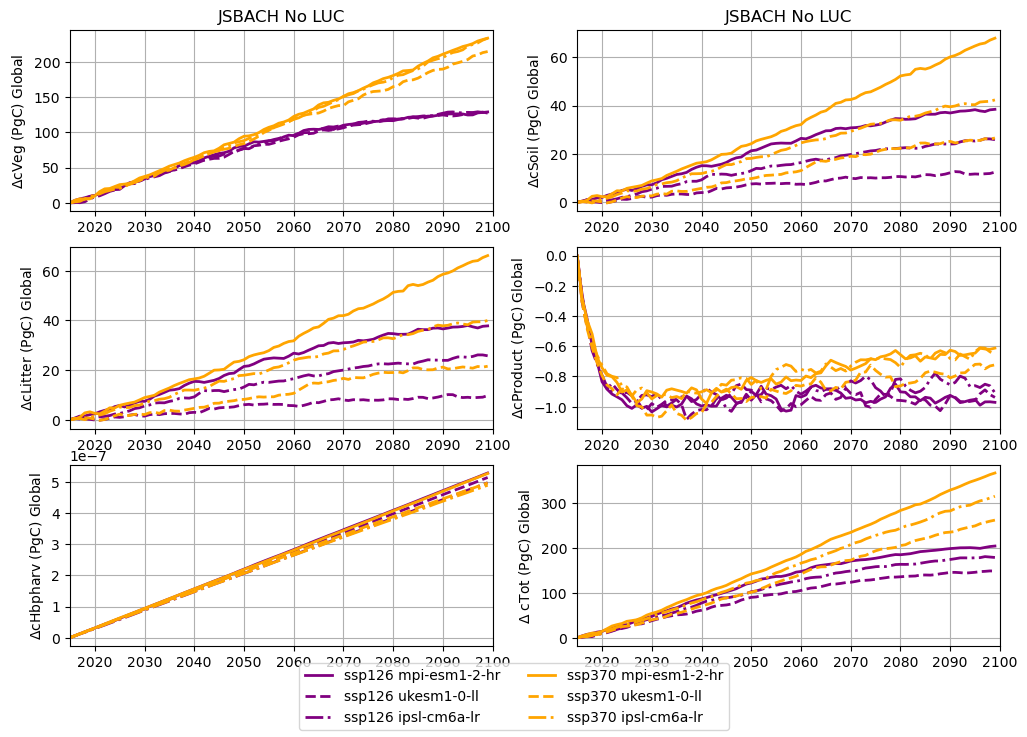

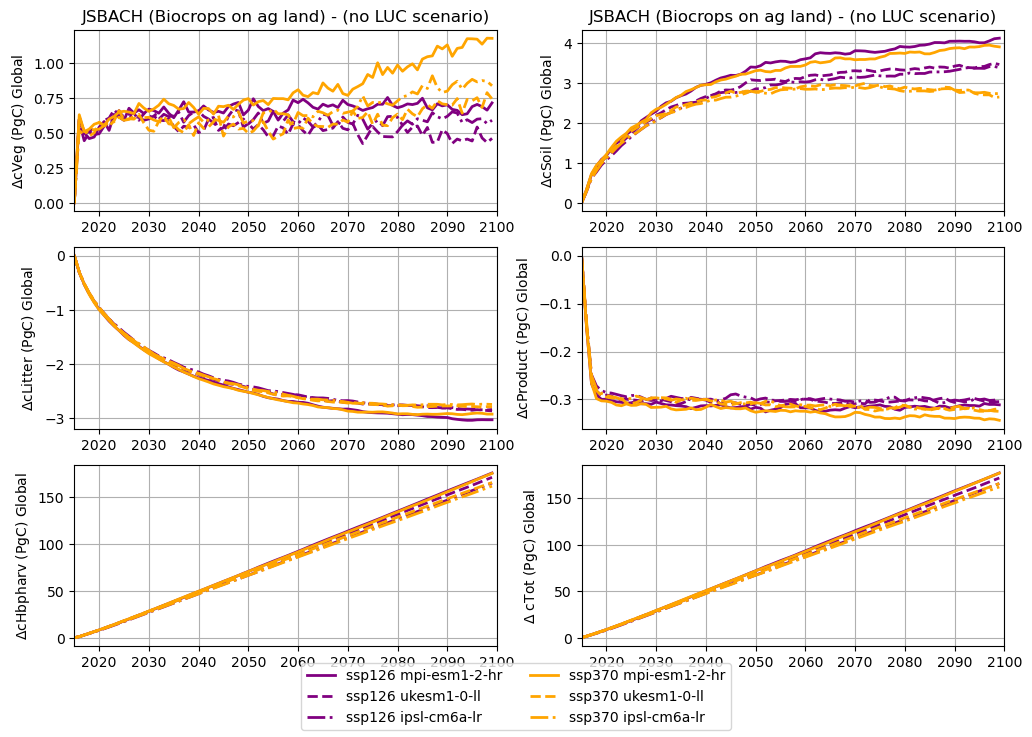

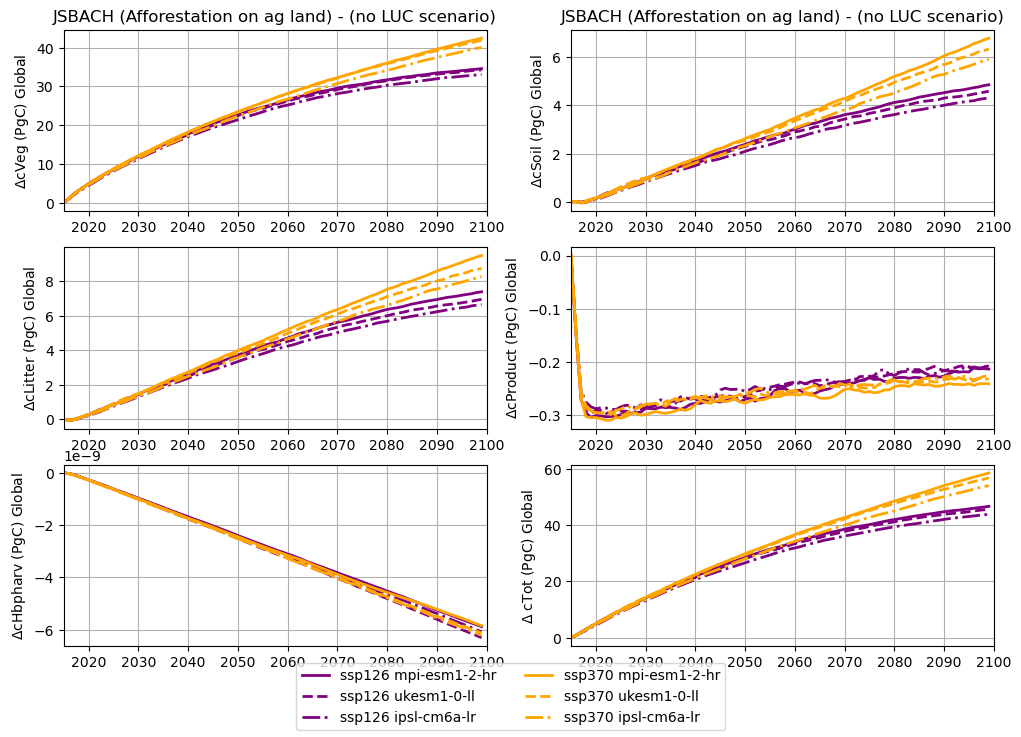

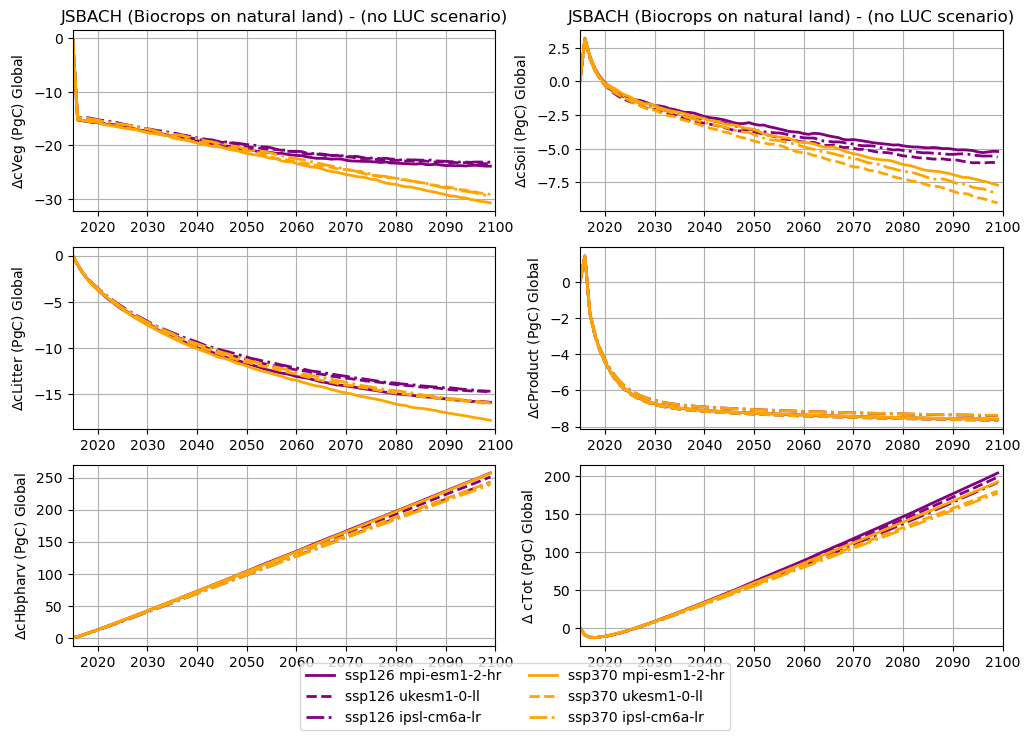

In [17]:
if __name__ == "__main__":
    main()